In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import math
import shapely.geometry
import pandas as pd
from geopy.distance import great_circle

In [2]:
#On lit la zone sur laquelle on travaille

Buffer = gpd.read_file('Part_Dieu_buffer_1km.shp')

In [3]:
#On lit le fichier contenant les toits plats, avec comme masque la zone précédente

ToitsPlats = gpd.read_file('ToitsPlatsPartDieu.shp',mask = Buffer)

C:\Users\maison\miniconda3\envs\gpd\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [6]:
#La legislation interdit de placer la végétalisation à moins de 50cm du bord du toit

ToitsPlats['geometry']=ToitsPlats['geometry'].buffer(-0.5)

In [7]:
#On crée une colonne surface pour pouvoir filtrer les toits trop petits
#Les professionnels du métier considèrent qu'un toit de moins de 50m2 ne vaut pas le coup d'être végétalisé

ToitsPlats['surf']=ToitsPlats['geometry'].area
ToitsPlats = ToitsPlats[ToitsPlats.surf > 50]

In [9]:
#On crée un champ périmètre qui nous sera utile plus tard

ToitsPlats['perimetre']=ToitsPlats['geometry'].length

In [10]:
#On calcule le RER

ToitsPlats['RER']=(ToitsPlats['surf'])/(ToitsPlats['surf']+(ToitsPlats['perimetre']*ToitsPlats['htotale']))

In [11]:
a = 0.03608 
b = 0.3691 
c = 1.561 
d = -0.2148 
e = 3.949 
f = -3.852

In [12]:
#On calcule le coefficient d'efficacité thermique

ToitsPlats['ET']=(a+b*ToitsPlats['RER']+c*ToitsPlats['RER']*ToitsPlats['RER']+e*ToitsPlats['RER']*ToitsPlats['RER']*ToitsPlats['RER']+f*ToitsPlats['RER']*ToitsPlats['RER']*ToitsPlats['RER']*ToitsPlats['RER'])*math.exp(d)

In [13]:
#On effectue une copie de notre dataframe pour pouvoir changer la géométrie en centroïdes

ToitsPlats2 = ToitsPlats.copy()

In [14]:
ToitsPlats2['geometry']=ToitsPlats2['geometry'].centroid

In [26]:
ToitsPlats2.to_crs(epsg=4326, inplace=True)

In [27]:
L=[]
for index2, row2 in ToitsPlats2.iterrows():
    if not row2['geometry'].is_empty :
        S=0
        for index, row in ToitsPlats2.iterrows():
            if not row['geometry'].is_empty :
                if great_circle(row2['geometry'].coords[0],row['geometry'].coords[0]).m < 200 :
                    S += row['surf']
        L.append(S)

In [28]:
#L devient notre indice l'indice de surface de toiture végétalisée aux alentours

ToitsPlats2['surf_autour']=L

In [15]:
#On réattribue les polygones aux centroïdes

ToitsPlats2['geometry']=ToitsPlats['geometry']

In [18]:
from t4gpd.morph.geoProcesses.SkyViewFactorOnTopOfRoof import SkyViewFactorOnTopOfRoof
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess

In [43]:
svfRoof = SkyViewFactorOnTopOfRoof(ToitsPlats2, nRays=16, maxRayLen=100.0, elevationFieldname='htotale')

SVF calculation method: Bernard et al. (2018), nRays = 16, maxRayLen = 100.0


In [44]:
ToitsPlats2.reset_index(drop = True, inplace = True)

In [45]:
result1 = STGeoProcess(svfRoof, ToitsPlats2).run()

In [49]:
result1.head(1)

,type,zmini,zmaxi,htotale,hfacade,numero,gid,geometry,surf,perimetre,RER,ET,svf_roof
0,Toit plan,192.7,192.7,25.6,25.6,83529,14966,"POLYGON ((845351.714 6519458.792, 845351.709 6...",844.166037,165.91346,0.165797,0.125259,0.929711


In [50]:
result1['SVV'] = result1['surf']*(1-result1['svf_roof'])

<AxesSubplot:>

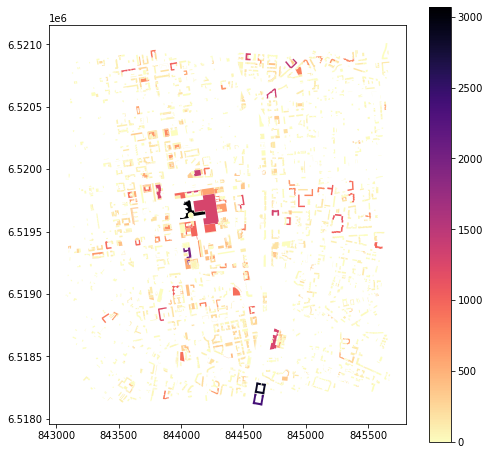

In [51]:
_ , basemap = plt.subplots(figsize=(8,8))
result1.plot(ax=basemap,column='SVV', cmap='magma_r', legend=True)